# FYS-STK4155 - Project 1

## By Jørn Marcus Høylo Rosenberg and Andreas Dyve

This Notebook contains both the code for the project and the report. The notebook is structured with each exercise in its own cell(s). This leads to some repeting code, but is practical for the purpose of evaluating each task seperately. (eller noe i denne duren?)

### Table of Contents

* [1. Imported libraries](#imports)
* [2. Functions used throughout the project](#functions)
    * [2.1. Franke function](#frankefunction)
    * [2.2. Cost functions](#costfunctions) 
    * [2.3. Design matrix function](#Xfunction)
    * [2.4. Scaling function](#scalefunction)
* [3. Exercise 1](#3)
    * [3.1. OLS regression](#3.1)
    * [3.2. Confidence intervals](#3.2)
    * [3.3. Discussion on scaling](3.3)
* [4. Exercise 2](#4)
    * [4.1. OLS regression with bootstrap](#4.1)
    * [4.2. bias-variance trade-off](#4.2)
* [5. Exercise 3](#5)
    * [5.1. OLS regression with cross-validation](#5.1)
    * [5.2. Comparison with bootstrap](#5.2)
* [6. Exercise 4](#6)
    * [6.1. Ridge regression with bootstrap and cross-validation](#6.1)
    * [6.2. Discussion of lambda](#6.2)
* [7. Exercise 5](#7)
    * [7.1 Lasso regression with bootstrap and cross-validation](#7.1)
    * [7.2 Evaluation of models](#7.2)
* [8. Exercise 6](#8)

### 1. Imported libraries <a class="anchor" id="imports"></a>

In [1]:
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.utils import resample

### 2. Functions used throughout the project <a class="anchor" id="functions"></a>

The following functions are used for much of the repetative tasks in this project

#### 2.1. Error functions <a class="anchor" id="errorfunctions"></a>

In [2]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

#### 2.2. Franke function <a class="anchor" id="frankefunction"></a>

The provided code in the exercise set is used for making of the Franke function.

In [56]:
def FrankeFunction(x,y,noise_coef):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = noise_coef * np.random.randn(N*N)
    return term1 + term2 + term3 + term4 + noise

#### 2.3. Design matrix function <a class="anchor" id="Xfunction"></a>

The provided code is used for computing the design matrix

In [57]:
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of columns in beta
    X = np.ones((N,l)) 

    for i in range(1,n+1):
        q = int((i)*(i+1)/2) 
        for k in range(i+1): 
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

#### 2.4. Scaling function <a class="anchor" id="scalefunction"></a>

In [58]:
def scale(X_train, X_test, z_train, z_test):
    scaler = StandardScaler() # Utilizing scikit's standardscaler

    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    scaler_z = scaler.fit(z_train.reshape(-1,1)) # Scaling z-data
    z_train_scaled = scaler_z.transform(z_train.reshape(-1,1)).ravel()
    z_test_scaled = scaler_z.transform(z_test.reshape(-1,1)).ravel()

    return X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled

## 3. Exercise 1: OLS on the Franke function <a class="anchor" id="3"></a>

The goal of this task is to do an OLS regression analysis of the Franke function for a polynomial degree up to 5. The OLS is implemented in the following way:
> $ \beta = $ blablba

#### 3.1. OLS regression code <a class="anchor" id="3.1"></a>

The following code creates the dataset and does an OLS regression analysis.

Degree: 0   mse train: 1.000000   mse test: 1.064366   r2_train: 0.000000   r2 test: -0.015059
Degree: 1   mse train: 0.385033   mse test: 0.429215   r2_train: 0.614967   r2 test: 0.590668
Degree: 2   mse train: 0.296313   mse test: 0.363751   r2_train: 0.703687   r2 test: 0.653100
Degree: 3   mse train: 0.224802   mse test: 0.228247   r2_train: 0.775198   r2 test: 0.782327
Degree: 4   mse train: 0.213184   mse test: 0.216487   r2_train: 0.786816   r2 test: 0.793542
Degree: 5   mse train: 0.205281   mse test: 0.213956   r2_train: 0.794719   r2 test: 0.795956


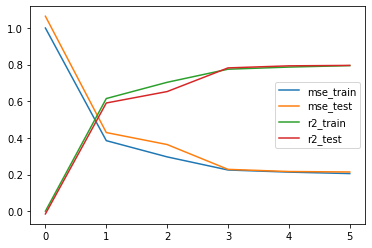

In [81]:
# Making meshgrid of datapoints and compute Franke's function
maxdegrees = 5
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15)

polydegree = np.zeros(maxdegrees+1)
r2_train = np.zeros(maxdegrees+1)
r2_test = np.zeros(maxdegrees+1)
mse_train = np.zeros(maxdegrees+1)
mse_test = np.zeros(maxdegrees+1)

# OLS regression for polynomials from 0 to maxdegrees
for i in range(maxdegrees+1):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2, random_state=42)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    # prediction
    betaOLS = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    ztilde_train = X_train @ betaOLS
    ztilde_test = X_test @ betaOLS
    
    # cost functions
    r2_train[i] = r2_score(z_train, ztilde_train)
    r2_test[i] = r2_score(z_test, ztilde_test)
    mse_train[i] = MSE(z_train,ztilde_train) 
    mse_test[i] = MSE(z_test,ztilde_test) #mean_squared_error(z_test, ztilde_test)
    print('Degree: %i   mse train: %.6f   mse test: %.6f   r2_train: %.6f   r2 test: %.6f'\
          %(degree, mse_train[i], mse_test[i], r2_train[i], r2_test[i]))

plt.plot(polydegree, mse_train, label='mse_train')
plt.plot(polydegree, mse_test, label='mse_test')
plt.plot(polydegree, r2_train, label='r2_train')
plt.plot(polydegree, r2_test, label='r2_test')
plt.legend()
plt.show()

#### 3.2. Confidence intervals <a class="anchor" id="3.2"></a>

- $\mu_{\beta} \pm \frac{2\sigma_{\beta}}{\sqrt{n}}$

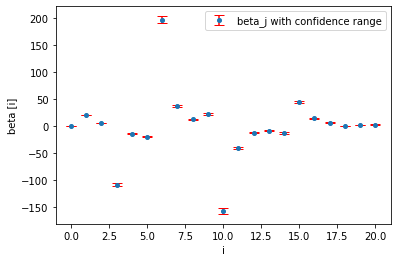

,Beta,+-
0,0.000000,0.000000
1,20.938894,0.686350
2,5.461345,0.207318
3,-107.922346,3.427664
4,-13.465913,0.785151
5,-19.006110,0.895333
6,197.001347,6.693252
7,36.921170,1.723331
8,13.213663,1.089970
9,22.064330,1.832442


In [82]:
variance = np.zeros(len(betaOLS))
CI = np.zeros(len(betaOLS))

for i in range(len(betaOLS)):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)

plt.errorbar(np.arange(0,len(betaOLS)), betaOLS, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='beta_j with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.legend()
plt.show()

table = pd.DataFrame({'Beta': betaOLS, '+-': CI})
table

#### 3.3 Discussion on scaling <a class="anchor" id="3.3"></a>

### 4. Exercise 2 - Bias-variance trade-off and resampling techniques 
<a class="anchor" id="4"></a>

#### Notes
- scaling or not scaling - no difference as expected (ref notes exercise 1)
- Increasing from 50 bootstraps gives no improved results
- Increasing N from 100 only smoothens the curve
- Polynomial degree above 10 does not decrease errors

#### 4.1. OLS regression with bootstrap resampling <a class="anchor" id="4.1"></a>

degree: 0    mse: 1.286153    bias: 1.286153    variance: 0.000000
degree: 1    mse: 0.483051    bias: 0.480727    variance: 0.002324
degree: 2    mse: 0.291993    bias: 0.286739    variance: 0.005254
degree: 3    mse: 0.081086    bias: 0.076465    variance: 0.004622
degree: 4    mse: 0.065672    bias: 0.060769    variance: 0.004904
degree: 5    mse: 0.084739    bias: 0.055375    variance: 0.029364
degree: 6    mse: 0.008771    bias: 0.007641    variance: 0.001130
degree: 7    mse: 0.014091    bias: 0.011589    variance: 0.002502
degree: 8    mse: 0.012344    bias: 0.009769    variance: 0.002575
degree: 9    mse: 0.053610    bias: 0.018838    variance: 0.034772
degree: 10    mse: 0.104077    bias: 0.014784    variance: 0.089294
degree: 11    mse: 0.098747    bias: 0.017607    variance: 0.081140


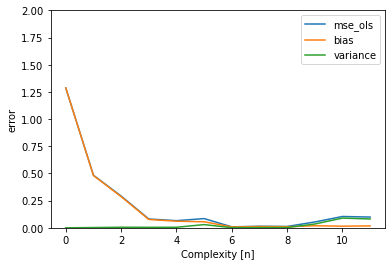

In [29]:
# Parameters
N = 20
n_bootstraps = 1000
maxdegree = 12

# Create data
np.random.seed(64)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15)

# Cost functions
mse_error = np.zeros(maxdegree)
r2_error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
mse_est = np.zeros(maxdegree)


polydegree = np.zeros(maxdegree)
for i in range(maxdegree):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)

    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train)
        beta_ols = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        z_pred[:,j] = X_test @ beta_ols
    
    mse_error[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True))
    bias[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[i] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    
    print('degree: %i    mse: %.6f    bias: %.6f    variance: %.6f' \
          %(degree, mse_error[i], bias[i], variance[i]))
    

plt.plot(polydegree, mse_error, label='mse_ols')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='variance')
plt.xlabel('Complexity [n]')
plt.ylabel('error')
plt.ylim(0,2)
plt.legend()
plt.show()

#### 4.2. Discussion of bias-variance trade-off <a class="anchor" id="4.2"></a>

### 5. Exercise 3 - Cross validation as resampling technique, adding more complexity 
<a class="anchor" id="5"></a>

#### 5.1. OLS regression with cross-validation resampling <a class="anchor" id="5.1"></a>

degree: 0    mse: 1.014967    scikit mse: -0.094468
degree: 1    mse: 0.543536    scikit mse: -0.050611
degree: 2    mse: 0.460891    scikit mse: -0.042991
degree: 3    mse: 0.327560    scikit mse: -0.030584
degree: 4    mse: 0.314723    scikit mse: -0.029365
degree: 5    mse: 0.298608    scikit mse: -0.027879
degree: 6    mse: 0.283374    scikit mse: -0.028802
degree: 7    mse: 0.293943    scikit mse: -0.031155
degree: 8    mse: 0.320473    scikit mse: -0.033205
degree: 9    mse: 0.368816    scikit mse: -0.036215
degree: 10    mse: 0.451438    scikit mse: -0.048001
degree: 11    mse: 0.619847    scikit mse: -0.060673


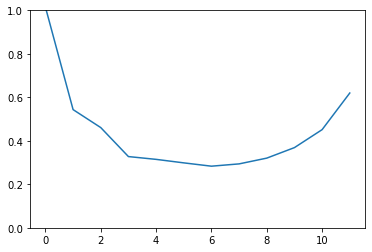

-0.06067256052363421


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Parameters
N = 20
maxdegree = 12
k = 10
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

# Make dataset
np.random.seed(64)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
z = FrankeFunction(x_flat, y_flat, 0.15)

# Cost function
mse_ols_cvd = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for i in range(maxdegree):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    mse_split = np.zeros(k)
    cv_split = 0
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred = X_test @ beta
        
        mse_split[cv_split] = mean_squared_error(z_test, z_pred)
        
        cv_split += 1
    
    mse_ols_cvd[i] = np.mean(mse_split)
    
    linreg = LinearRegression()
    mse_scikit_cv = np.mean(cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold))
    
    print('degree: %i    mse: %.6f    scikit mse: %.6f' %(degree, mse_ols_cvd[i], mse_scikit_cv))
    
plt.plot(polydegree, mse_ols_cvd)
plt.ylim(0,1)
plt.show()
    

print(mse_scikit_cv)
#print('mse with scikit: %.6f' %(mse_scikit_cv))

#### 5.2. Comments <a class="anchor" id="5.2"></a>

### 6. Exercise 4 - Ridge regression on the Franke function with resampling
<a class="anchor" id="4"></a>

- Ridge: Shrinking beta-coefficients with large variance, but never to zero
- Lasso: Same, but can shrink to zero
- Noisy function means large variance
- To compare OLS/ridge/beta, try to compute coefficients and see with/without noise
- Beta coefficients in ridge are given by Gaussian distribution, in Lasso they are given by Laplace distribution (thats why they can go to zero)

- Scaling: Subtracting the mean value means first column of design matrix (1,1,1,...) becomes zero.

#### 6.1. Ridge regression with bootstrap and cross validation <a class="anchor" id="6.1"></a>

hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei


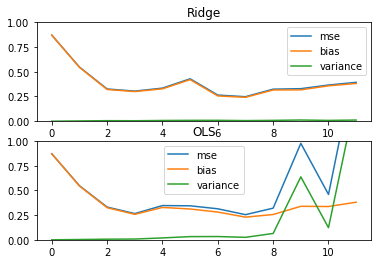

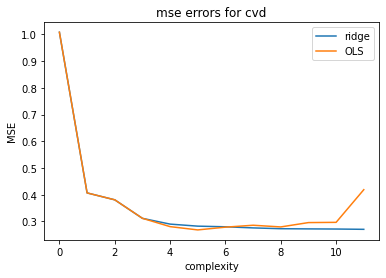

In [10]:
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
np.random.seed(64)

z = FrankeFunction(x_flat, y_flat, 0.15) 

#Bootstrap parameters
n_bootstraps = 1000
maxdegree = 12

#cross_validation parameters
k = 10
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

polydegrees = np.zeros(maxdegree)

#Error arrays
mse_ridge_bootstrap = np.zeros(maxdegree)
mse_ols_bootstrap = np.zeros(maxdegree)

bias_ridge_bootstrap = np.zeros(maxdegree)
bias_ols_bootstrap = np.zeros(maxdegree)

variance_ridge_bootstrap = np.zeros(maxdegree)
variance_ols_bootstrap = np.zeros(maxdegree)

mse_ridge_cvd = np.zeros(maxdegree)
mse_ols_cvd = np.zeros(maxdegree)

for i in range(maxdegree):
    degree = i
    polydegrees[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    z_pred_ridge_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ols_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        lmd = 1
        
        x_bs,z_bs = resample(X_train,z_train
                            )
        beta_ridge_bootstrap = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1],x_bs.shape[1])) @ x_bs.T @ z_bs
        beta_ols_bootstrap = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        
        z_pred_ridge_bootstrap[:,j] = X_test @ beta_ridge_bootstrap
        z_pred_ols_bootstrap[:,j] = X_test @ beta_ols_bootstrap
    
    #Bootstrap errors
    mse_ridge_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_bootstrap)**2, axis=1, keepdims=True))
    mse_ols_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ols_bootstrap)**2, axis=1, keepdims=True))
    
    bias_ridge_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge_bootstrap, axis=1, keepdims=True))**2)
    bias_ols_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ols_bootstrap, axis=1, keepdims=True))**2)
    
    variance_ridge_bootstrap[i] = np.mean(np.var(z_pred_ridge_bootstrap, axis=1, keepdims=True))
    variance_ols_bootstrap[i] = np.mean(np.var(z_pred_ols_bootstrap, axis=1, keepdims=True))
    
    #print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f    bias: %.4f    variance: %.4f'\
     #     %(degree, lmb, mse_ridge_bootstrap[i], mse_ols_bootstrap[i], bias_ridge_bootstrap[i],\
      #     variance_ols_bootstrap[i]))
    
    
    cv_split = 0
    mse_ols_cvd_split = np.zeros(k)
    mse_ridge_cvd_split = np.zeros(k)
    

    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
        
        lmd = 0.01
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        
        beta_ols_cvd = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred_ols_cvd = X_test @ beta_ols_cvd
        
        beta_ridge_cvd = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
        z_pred_ridge_cvd = X_test @ beta_ridge_cvd
        
        mse_ols_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ols_cvd)
        mse_ridge_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ridge_cvd)
    
        cv_split += 1
    
    print('hei')
    # Cvd errors
    mse_ridge_cvd[i] = np.mean(mse_ridge_cvd_split)
    mse_ols_cvd[i] = np.mean(mse_ols_cvd_split)
    
    #print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f' %(degree, lmb, mse_error_ridge_cvd[i], mse_error_ols_cvd[i]))


# Endre plot til subplots
fig,ax = plt.subplots(2, sharey=True)
ax[0].plot(polydegrees, mse_ridge_bootstrap, label='mse')
ax[0].plot(polydegrees, bias_ridge_bootstrap, label='bias')
ax[0].plot(polydegrees, variance_ridge_bootstrap, label='variance')
ax[0].set_ylim(0,1)
ax[0].legend()
ax[0].set_title('Ridge')

ax[1].plot(polydegrees, mse_ols_bootstrap, label='mse')
ax[1].plot(polydegrees, bias_ols_bootstrap, label='bias')
ax[1].plot(polydegrees, variance_ols_bootstrap, label='variance')
ax[1].legend()
ax[1].set_title('OLS')
plt.show()

fig,ax = plt.subplots(1, sharey=True)
ax.plot(polydegrees, mse_ridge_cvd, label='ridge')
ax.plot(polydegrees, mse_ols_cvd, label='OLS')
ax.set_xlabel('complexity')
ax.set_ylabel('MSE')
ax.legend()
plt.title('mse errors for cvd')
plt.show()

#### 6.2. Discussion of lambda dependence <a class="anchor" id="6.2"></a>

#### 6.3. Discussion of bias-variance trade-off  <a class="anchor" id="6.3"></a>

### 7. Exercise 5 - Lasso Regression on the Franke function with resampling
<a class="anchor" id="7"></a>

#### 7.1. Lasso regression

Polynomial degree: 0
Bootstrap
        mse        bias        variance
OLS     0.81720     0.81720     0.00000
Ridge   0.81720     0.81720     0.00000
Lasso   0.81720     0.81720     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.94069    0.94069    0.94069
Split: 2    0.86472    0.86472    0.86472
Split: 3    0.73613    0.73613    0.73613
Split: 4    1.09421    1.09421    1.09421
Split: 5    1.43658    1.43658    1.43658
 
Avg cvd OLS mse for polynomial degree 0: 1.01447
Avg cvd Ridge mse for polynomial degree 0: 1.01447
Avg cvd Lasso mse for polynomial degree 0: 1.01447
 
Polynomial degree: 1
Bootstrap
        mse        bias        variance
OLS     0.51654     0.51398     0.00256
Ridge   0.51654     0.51398     0.00256
Lasso   0.51349     0.51349     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.50481    0.50481    0.50469
Split: 2    0.40064    0.40064    0.40061
Split: 3    0.37554    0.37554 

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.973118024399568, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.973118024399568, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.973118024399568, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

OLS     0.33700     0.32595     0.01105
Ridge   0.33682     0.32582     0.01100
Lasso   0.32428     0.32428     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.28007    0.28018    0.30082
Split: 2    0.29160    0.29120    0.27446
Split: 3    0.27290    0.27267    0.26626
Split: 4    0.31895    0.31908    0.33723
Split: 5    0.35305    0.35336    0.39088
 
Avg cvd OLS mse for polynomial degree 3: 0.30331
Avg cvd Ridge mse for polynomial degree 3: 0.30330
Avg cvd Lasso mse for polynomial degree 3: 0.31393
 
Polynomial degree: 4
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.33225940466383, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.33225940466383, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.33225940466383, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.33225940466383, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.33225940466383, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.33225940466383, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

OLS     0.24931     0.23750     0.01181
Ridge   0.24848     0.23777     0.01072
Lasso   0.26427     0.26427     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.28112    0.27861    0.29309
Split: 2    0.27067    0.27313    0.27572
Split: 3    0.26436    0.26357    0.26347
Split: 4    0.33565    0.32728    0.33188
Split: 5    0.31265    0.31735    0.38299
 
Avg cvd OLS mse for polynomial degree 4: 0.29289
Avg cvd Ridge mse for polynomial degree 4: 0.29199
Avg cvd Lasso mse for polynomial degree 4: 0.30943
 
Polynomial degree: 5
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4453002469180234, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4453002469180234, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4453002469180234, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4453002469180234, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4453002469180234, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4453002469180234, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

OLS     0.28425     0.26703     0.01723
Ridge   0.26066     0.24586     0.01480
Lasso   0.25567     0.25567     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.26146    0.26986    0.29007
Split: 2    0.23776    0.25756    0.27340
Split: 3    0.26399    0.27189    0.26073
Split: 4    0.32012    0.32928    0.32708
Split: 5    0.30177    0.32766    0.38081
 
Avg cvd OLS mse for polynomial degree 5: 0.27702
Avg cvd Ridge mse for polynomial degree 5: 0.29125
Avg cvd Lasso mse for polynomial degree 5: 0.30642
 
Polynomial degree: 6
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0471025730572876, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0471025730572876, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0471025730572876, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0471025730572876, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0471025730572876, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0471025730572876, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

OLS     0.26554     0.23931     0.02622
Ridge   0.21715     0.20244     0.01471
Lasso   0.21028     0.21028     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.27165    0.26669    0.28974
Split: 2    0.26817    0.25016    0.27329
Split: 3    0.26205    0.27217    0.25971
Split: 4    0.32530    0.32250    0.32607
Split: 5    0.30092    0.32232    0.37492
 
Avg cvd OLS mse for polynomial degree 6: 0.28562
Avg cvd Ridge mse for polynomial degree 6: 0.28677
Avg cvd Lasso mse for polynomial degree 6: 0.30475
 
Polynomial degree: 7
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.976521324337497, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.976521324337497, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.976521324337497, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/skle

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.976521324337497, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.976521324337497, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.976521324337497, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/skle

OLS     0.36034     0.32252     0.03782
Ridge   0.34527     0.32899     0.01627
Lasso   0.34390     0.34390     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.25973    0.26853    0.29071
Split: 2    0.26246    0.24671    0.27221
Split: 3    0.26175    0.26706    0.26087
Split: 4    0.33431    0.31743    0.33095
Split: 5    0.33678    0.31976    0.37031
 
Avg cvd OLS mse for polynomial degree 7: 0.29100
Avg cvd Ridge mse for polynomial degree 7: 0.28390
Avg cvd Lasso mse for polynomial degree 7: 0.30501
 
Polynomial degree: 8
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.211970547436856, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.211970547436856, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.211970547436856, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/skle

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.211970547436856, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.211970547436856, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.211970547436856, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/skle

OLS     0.27313     0.22876     0.04436
Ridge   0.25601     0.24141     0.01459
Lasso   0.27419     0.27419     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.28207    0.26954    0.29139
Split: 2    0.25025    0.24517    0.27237
Split: 3    0.27061    0.26311    0.26429
Split: 4    0.34416    0.31651    0.32954
Split: 5    0.32051    0.31895    0.36250
 
Avg cvd OLS mse for polynomial degree 8: 0.29352
Avg cvd Ridge mse for polynomial degree 8: 0.28266
Avg cvd Lasso mse for polynomial degree 8: 0.30402
 
Polynomial degree: 9
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.186672497785636, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.186672497785636, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.186672497785636, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.186672497785636, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.186672497785636, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.186672497785636, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

OLS     0.57275     0.34969     0.22306
Ridge   0.33694     0.31207     0.02487
Lasso   0.36063     0.36063     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.27840    0.26917    0.29196
Split: 2    0.25329    0.24480    0.27375
Split: 3    0.28414    0.26271    0.26523
Split: 4    0.34669    0.31961    0.33005
Split: 5    0.33242    0.32046    0.35657
 
Avg cvd OLS mse for polynomial degree 9: 0.29899
Avg cvd Ridge mse for polynomial degree 9: 0.28335
Avg cvd Lasso mse for polynomial degree 9: 0.30351
 
Polynomial degree: 10
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3304342498739885, tolerance: 0.03199999999999999
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3304342498739885, tolerance: 0.03199999999999999
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3304342498739885, tolerance: 0.03199999999999999
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3304342498739885, tolerance: 0.03199999999999999
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3304342498739885, tolerance: 0.03199999999999999
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3304342498739885, tolerance: 0.03199999999999999
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

OLS     0.38492     0.24236     0.14257
Ridge   0.26203     0.24200     0.02003
Lasso   0.27536     0.27536     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.26921    0.26826    0.29238
Split: 2    0.45270    0.24533    0.27088
Split: 3    0.29369    0.26450    0.26539
Split: 4    0.33577    0.32483    0.32834
Split: 5    0.33132    0.32233    0.35443
 
Avg cvd OLS mse for polynomial degree 10: 0.33654
Avg cvd Ridge mse for polynomial degree 10: 0.28505
Avg cvd Lasso mse for polynomial degree 10: 0.30228
 
Polynomial degree: 11
Bootstrap
        mse        bias        variance


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973230248556945, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973230248556945, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973230248556945, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973230248556945, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973230248556945, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973230248556945, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

OLS     0.49667     0.27679     0.21987
Ridge   0.27110     0.24701     0.02410
Lasso   0.25345     0.25345     0.00000

Cross-validation mse errors
             ols        ridge     lasso
Split: 1    0.26299    0.26775    0.29218
Split: 2    0.60419    0.24642    0.27028
Split: 3    0.28469    0.26607    0.26523
Split: 4    0.33845    0.33005    0.32631
Split: 5    0.37554    0.32324    0.35355
 
Avg cvd OLS mse for polynomial degree 11: 0.37317
Avg cvd Ridge mse for polynomial degree 11: 0.28671
Avg cvd Lasso mse for polynomial degree 11: 0.30151
 


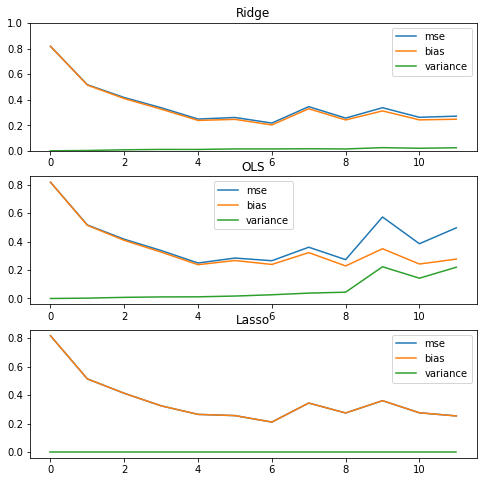

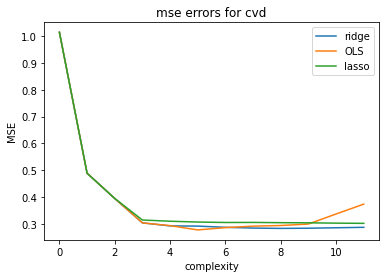

In [94]:
from sklearn.linear_model import Lasso

# Make data
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
np.random.seed(64)

z = FrankeFunction(x_flat, y_flat, 0.15) 

# Bootstrap parameters
n_bootstraps = 50
maxdegree = 12

# Cross-validation parameters
k = 5
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

polydegrees = np.zeros(maxdegree)

#Error arrays

# Bootstrap
mse_ols_bootstrap = np.zeros(maxdegree)
mse_ridge_bootstrap = np.zeros(maxdegree)
mse_lasso_bootstrap = np.zeros(maxdegree)

bias_ols_bootstrap = np.zeros(maxdegree)
bias_ridge_bootstrap = np.zeros(maxdegree)
bias_lasso_bootstrap = np.zeros(maxdegree)

variance_ols_bootstrap = np.zeros(maxdegree)
variance_ridge_bootstrap = np.zeros(maxdegree)
variance_lasso_bootstrap = np.zeros(maxdegree)

# cvd
mse_ols_cvd = np.zeros(maxdegree)
mse_ridge_cvd = np.zeros(maxdegree)
mse_lasso_cvd = np.zeros(maxdegree)

lmd = 0.001
for i in range(maxdegree):
    degree = i
    polydegrees[i] = degree
    print("Polynomial degree: %i" %(i))
    
    X = create_X(x_flat, y_flat, degree)
    

    # Bootstrap
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    z_pred_ridge_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ols_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_lasso_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    
    print("Bootstrap")
    print("        mse        bias        variance")
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train,z_train)
        
        beta_ols_bootstrap = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        beta_ridge_bootstrap = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1],x_bs.shape[1])) @ x_bs.T @ z_bs
        
        z_pred_ols_bootstrap[:,j] = X_test @ beta_ols_bootstrap
        z_pred_ridge_bootstrap[:,j] = X_test @ beta_ridge_bootstrap
        
        reglasso_bootstrap = Lasso(lmd)
        reglasso_bootstrap.fit(X_train, z_train)
        z_pred_lasso_bootstrap[:,j] = reglasso_bootstrap.predict(X_test)
    
    
    mse_ols_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ols_bootstrap)**2, axis=1, keepdims=True))
    mse_ridge_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_bootstrap)**2, axis=1, keepdims=True))
    mse_lasso_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_lasso_bootstrap)**2, axis=1, keepdims=True))
    
    bias_ols_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ols_bootstrap, axis=1, keepdims=True))**2)
    bias_ridge_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge_bootstrap, axis=1, keepdims=True))**2)
    bias_lasso_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_lasso_bootstrap, axis=1, keepdims=True))**2)
    
    variance_ols_bootstrap[i] = np.mean(np.var(z_pred_ols_bootstrap, axis=1, keepdims=True))
    variance_ridge_bootstrap[i] = np.mean(np.var(z_pred_ridge_bootstrap, axis=1, keepdims=True))
    variance_lasso_bootstrap[i] = np.mean(np.var(z_pred_lasso_bootstrap, axis=1, keepdims=True))
    
    print("OLS     %.5f     %.5f     %.5f"\
          %(mse_ols_bootstrap[i],bias_ols_bootstrap[i],variance_ols_bootstrap[i]))
    
    print("Ridge   %.5f     %.5f     %.5f"\
          %(mse_ridge_bootstrap[i],bias_ridge_bootstrap[i],variance_ridge_bootstrap[i]))
   
    print("Lasso   %.5f     %.5f     %.5f"\
          %(mse_lasso_bootstrap[i],bias_lasso_bootstrap[i],variance_lasso_bootstrap[i]))
    
    
    """
    print("OLS")
    print("mse: %.5f    mse ridge: %.5f    mse lasso: %.5f"\
          %(mse_ols_bootstrap[i], mse_ridge_bootstrap[i], mse_lasso_bootstrap[i]))
    print("bias ols: %.5f    bias ridge: %.5f    bias lasso: %.5f"\
          %(bias_ols_bootstrap[i], bias_ridge_bootstrap[i], bias_lasso_bootstrap[i]))
    print("variance ols: %.5f     variance ridge: %.5f    variance lasso: %.5f"\
          %(variance_ols_bootstrap[i], variance_ridge_bootstrap[i], variance_lasso_bootstrap[i]))
    print(" ")
    """
    # cvd
    cv_split = 0
    mse_ols_cvd_split = np.zeros(k)
    mse_ridge_cvd_split = np.zeros(k)
    mse_lasso_cvd_split = np.zeros(k)
    
    print("")
    print("Cross-validation mse errors")
    print("             ols        ridge     lasso")
    for train_indexes, test_indexes in kfold.split(X):
        
        # Split and scale
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
        
        # Make beta
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        beta_ols_cvd = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        beta_ridge_cvd = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
        
        # Predictions
        z_pred_ols_cvd = X_test @ beta_ols_cvd
        z_pred_ridge_cvd = X_test @ beta_ridge_cvd
        
        reglasso_cvd = Lasso(lmd, max_iter=1e5, tol=0.001)
        reglasso_cvd.fit(X_train, z_train)
        z_pred_lasso_cvd = reglasso_cvd.predict(X_test)
        
        # Errors
        mse_ols_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ols_cvd)
        mse_ridge_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ridge_cvd)
        mse_lasso_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_lasso_cvd)
        
        print("Split: %i    %.5f    %.5f    %.5f"\
              %(cv_split+1, mse_ols_cvd_split[cv_split], mse_ridge_cvd_split[cv_split]\
                ,mse_lasso_cvd_split[cv_split]))
        
        
        cv_split += 1
    
    # Cvd errors
    mse_ridge_cvd[i] = np.mean(mse_ridge_cvd_split)
    mse_ols_cvd[i] = np.mean(mse_ols_cvd_split)
    mse_lasso_cvd[i] = np.mean(mse_lasso_cvd_split)
    
    print(" ")
    print("Avg cvd OLS mse for polynomial degree %i: %.5f" %(degree, mse_ols_cvd[i]))
    print("Avg cvd Ridge mse for polynomial degree %i: %.5f" %(degree, mse_ridge_cvd[i]))
    print("Avg cvd Lasso mse for polynomial degree %i: %.5f" %(degree, mse_lasso_cvd[i]))
    print(" ")
    
    

# Bootstrap plots
fig,ax = plt.subplots(3,figsize=(8,8))
ax[0].plot(polydegrees, mse_ridge_bootstrap, label='mse')
ax[0].plot(polydegrees, bias_ridge_bootstrap, label='bias')
ax[0].plot(polydegrees, variance_ridge_bootstrap, label='variance')
ax[0].set_ylim(0,1)
ax[0].legend()
ax[0].set_title('Ridge')

ax[1].plot(polydegrees, mse_ols_bootstrap, label='mse')
ax[1].plot(polydegrees, bias_ols_bootstrap, label='bias')
ax[1].plot(polydegrees, variance_ols_bootstrap, label='variance')
ax[1].legend()
ax[1].set_title('OLS')

ax[2].plot(polydegrees, mse_lasso_bootstrap, label='mse')
ax[2].plot(polydegrees, bias_lasso_bootstrap, label='bias')
ax[2].plot(polydegrees, variance_lasso_bootstrap, label='variance')
ax[2].legend()
ax[2].set_title('Lasso')

# cvd plot
fig,ax = plt.subplots(1)
ax.plot(polydegrees, mse_ridge_cvd, label='ridge')
ax.plot(polydegrees, mse_ols_cvd, label='OLS')
ax.plot(polydegrees, mse_lasso_cvd, label='lasso')
ax.set_xlabel('complexity')
ax.set_ylabel('MSE')
ax.legend()
plt.title('mse errors for cvd')

plt.show()

#### 7.2. Evaluation of methods  <a class="anchor" id="7.2"></a>